# Model comparison

In [3]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import cross_validate_model
#from plotting_functions import cross_validate_model, plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates

one = ONE()

## Parameters

In [4]:
bin_size = 0.1
num_iters = 100
num_train_batches = 5
last_state = 60  # Test up until last_state Ks
state_step = 5
start_step = 2
method = 'kmeans'

### Get design matrices

In [5]:

data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + str(bin_size) + '/'
os.chdir(data_path)
design_matrices = os.listdir(data_path)

## Preprocess list of design matrices

In [6]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices):
   
    # Trials data
    session = design_matrices[m][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin']<session_end*10) & (design_matrix['Bin']>session_start*10)]

    training_set = np.array(design_matrix[var_names]).copy() 
    
    """
    # Keep some fraction of the data for the test set and don't touch it!
    inpt = training_set
    split_parts = 5
    length = len(inpt)// split_parts * split_parts
    training_length = int(length - (length/5))
    test_length = int(length/5)
    
    # Leave test set as the middle 5th part (to avoid effects of early/late session)
    training_set = jnp.concatenate([inpt[:test_length*2], inpt[-test_length*2:]])
    test_set = inpt[test_length*2:test_length*3]
    """
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)  # norm='max'
      normalized = normalizer.transform(standardized)
      
      # Save results
      matrix_all[mat].append(normalized)
      session_all[mat].append(session_trials)
    

2. Preprocess design matrix constructed from PCs

In [ ]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
os.chdir(data_path)

datasets = ["design_matrix_dim_reduc_0.1"]

matrix_all_bins = defaultdict(list)

for b, binning in enumerate(datasets):
    big_design_matrix = pickle.load(open(binning, "rb"))

    design_matrix = big_design_matrix.dropna()

    # Move 
    inpt = np.array(design_matrix[['pc1', 'pc2', 'pc3', 'pc4']]).copy() # keep only first 4 PC (based on variance explained plot (see dimensionality_reduction.ipynb))
    split_parts = 5
    length = len(inpt)// split_parts * split_parts
    training_length = int(length - (length/5))
    training_set = inpt[:training_length, :]
    
    # Standardization using StandardScaler
    #scaler = StandardScaler()
    #standardized_matrix = scaler.fit_transform(inpt)

    standardized_matrix = training_set

    # Save design matrix    
    matrix_all_bins[binning].append(training_set)

## Cross-validate and compare models with different K and different time resolutions

In [ ]:
binning_lengths = [0.03, 0.05, 0.1]
binning_lengths = [0.1]
for c, binning in enumerate(binning_lengths):
    
    print('Fitting models with ' + str(binning) + ' time resolution')
    # Shorten array so that equal division is possible
    standardized_matrix = matrix_all_bins['design_matrix_v2_' + str(example_session) + '_' + str(binning)]
    #standardized_matrix = matrix_all_bins['design_matrix_v2_' + str(binning)]

    emission_dim = np.shape(standardized_matrix[0])[1]
    num_timesteps = np.shape(standardized_matrix[0])[0]
    
    shortened_array = standardized_matrix[0][:num_timesteps // num_train_batches * num_train_batches]
    # Split data into folds
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
    fold_len =  len(shortened_array)/num_train_batches

    # Make a range of Gaussian HMMs
    all_num_states = list(range(2, last_state, state_step))
    test_hmms = [GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
    results = []
    for test_hmm in test_hmms:
        print(f"fitting model with {test_hmm.num_states} states")
        results.append(cross_validate_model(test_hmm, jr.PRNGKey(0), train_emissions, num_train_batches))

    all_val_lls, fit_params, init_params, baseline_lls = tuple(zip(*results))
    
    if c == 0:
        binning_lls = np.nanmean(all_val_lls, axis=1)
        binning_baseline_lls = np.nanmean(baseline_lls, axis=1)
    else:
        binning_lls = np.vstack((binning_lls, np.nanmean(all_val_lls, axis=1)))
        binning_baseline_lls = np.vstack((binning_baseline_lls, np.nanmean(baseline_lls, axis=1)))

Fitting models with 0.1 time resolution


NameError: name 'matrix_all_bins' is not defined

## Cross-validate and compare models for each session

In [ ]:
# Initialize vars for saving results
all_init_params = defaultdict(list)
all_fit_params = defaultdict(list)

for s, ses in enumerate(design_matrices[1:2]):
    
    session = session_all[ses]
    print('Fitting session ' + str(ses[14:-4]))
    
    # Shorten array so that equal division is possible
    standardized_matrix = matrix_all[ses]
    
    if len(standardized_matrix) > 0:
        
        emission_dim = np.shape(standardized_matrix[0])[1]
        num_timesteps = np.shape(standardized_matrix[0])[0]
        
        shortened_array = standardized_matrix[0][:num_timesteps // num_train_batches * num_train_batches]
        
        # Split data into folds
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        fold_len =  len(shortened_array)/num_train_batches

        # Make a range of Gaussian HMMs
        all_num_states = list(range(start_step, last_state, state_step))
        test_hmms = [GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.) 
            for num_states in all_num_states]
        results = []
        for test_hmm in test_hmms:
            print(f"fitting model with {test_hmm.num_states} states")
            results.append(cross_validate_model(test_hmm, jr.PRNGKey(0), shortened_array, train_emissions, method, num_train_batches))

        all_val_lls, fit_params, init_params, baseline_lls, train_lps = tuple(zip(*results))
        
        # Save results
        if s == 0:
            all_lls = np.nanmean(all_val_lls, axis=1)
            train_lls = np.array(train_lps)
            all_baseline_lls = np.nanmean(baseline_lls, axis=1)
        else:
            all_lls = np.vstack((all_lls, np.nanmean(all_val_lls, axis=1)))
            train_lls = np.vstack((train_lls, np.array(train_lps)))
            all_baseline_lls = np.vstack((all_baseline_lls, np.nanmean(baseline_lls, axis=1)))
            
        # Save params
        all_init_params[ses].append(init_params)
        all_fit_params[mat].append(fit_params)


Fitting session 9b5a1754-ac99-4d53-97d3-35c2f6638507
fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

5375.0


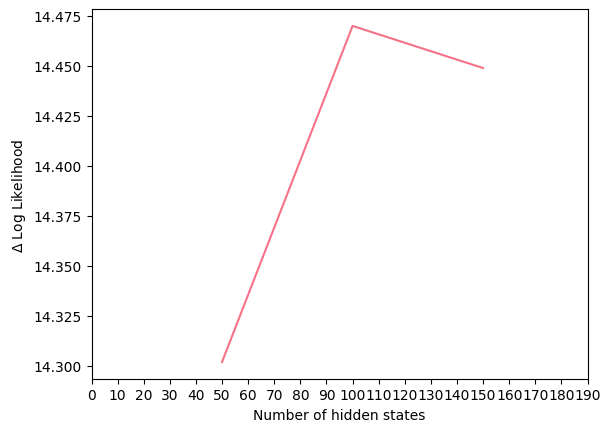

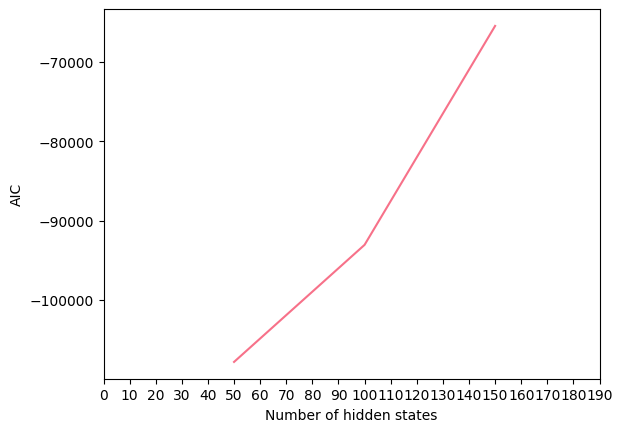

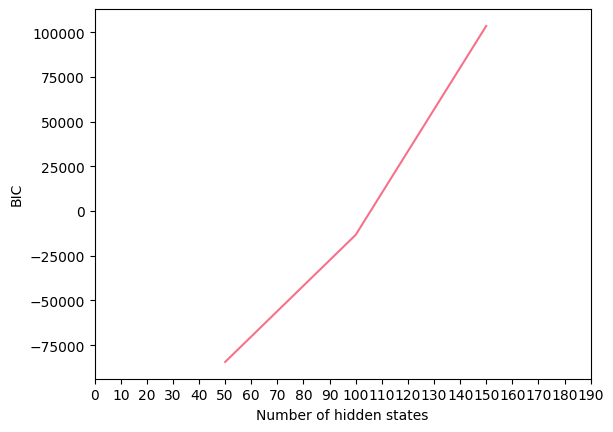

In [ ]:
States = list(range(start_step, last_state, state_step))

def generate_colors(num_colors):
    # Use seaborn's color_palette to generate a list of colors
    return sns.color_palette('husl', n_colors=num_colors)

# Generate the list of colors
colors = generate_colors(len(matrix_all))
Ks = np.array([(num_states + num_states*num_states + num_states*emission_dim*2) 
          for num_states in States])  # pi_init + transition_matrix + predictors_mean + predictors_var 

for s, session in enumerate(design_matrices[0:1]):
    # Shorten array so that equal division is possible
    standardized_matrix = matrix_all[session]
    if len(standardized_matrix) > 0:
        
        emission_dim = np.shape(standardized_matrix[0])[1]
        num_timesteps = np.shape(standardized_matrix[0])[0]
        
        shortened_array = standardized_matrix[0][:num_timesteps // num_train_batches * num_train_batches]
        
        # Split data into folds
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        fold_len =  len(shortened_array)/num_train_batches
        print(fold_len)
        
        avg_val_lls = all_lls[s]
        avg_val_lls = all_lls
        baseline_lls = all_baseline_lls[s]
        baseline_lls = all_baseline_lls
        bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
        
        plt.plot(all_num_states, bits_LL, color=colors[s], label=str(session))
        plt.legend()
        plt.xticks(States)
        plt.xlabel("Number of hidden states")
        plt.ylabel("$\Delta$ Log Likelihood ")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.xticks(np.arange(0, last_state, 10), np.arange(0, last_state, 10))
plt.legend().remove()
#plt.ylim([4,5])
plt.show()

for s, session in enumerate(design_matrices[0:1]):

    avg_val_lls = all_lls[s]
    avg_val_lls = all_lls
    AIC = Ks * 2 - 2 * np.array(avg_val_lls)
    plt.plot(all_num_states, AIC, color=colors[s], label=str(session))
    plt.xticks(States)
    plt.xlabel("Number of hidden states")
    plt.ylabel("AIC")
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.legend().remove()
plt.xticks(np.arange(0, last_state, 10), np.arange(0, last_state, 10))
plt.show()


for s, session in enumerate(design_matrices[0:1]):
    # Shorten array so that equal division is possible
    standardized_matrix = matrix_all[session]
    if len(standardized_matrix) > 0:
        
        emission_dim = np.shape(standardized_matrix[0])[1]
        num_timesteps = np.shape(standardized_matrix[0])[0]
        
        shortened_array = standardized_matrix[0][:num_timesteps // num_train_batches * num_train_batches]
        
        # Split data into folds
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        fold_len =  len(shortened_array)/num_train_batches
        
        avg_val_lls = all_lls[s]
        avg_val_lls = all_lls
        BIC = Ks * np.log(fold_len) - 2 * np.array(avg_val_lls)
        #BIC = Ks * np.log(fold_len) - 2 * np.array(train_lls)
        plt.plot(all_num_states, BIC, color=colors[s], label=str(session))
        plt.legend()
        plt.xticks(States)
        plt.xlabel("Number of hidden states")
        plt.ylabel("BIC")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.xticks(np.arange(0, last_state, 10), np.arange(0, last_state, 10))
plt.legend().remove()

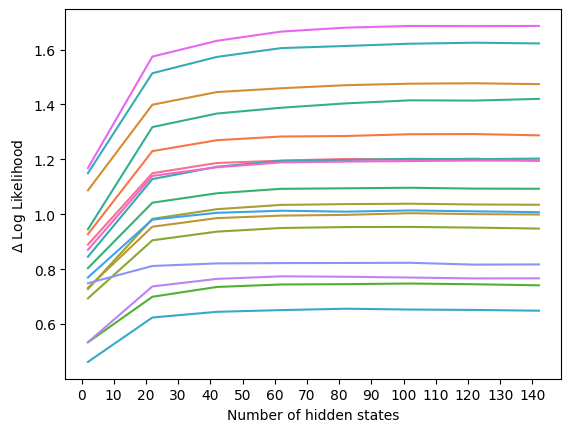

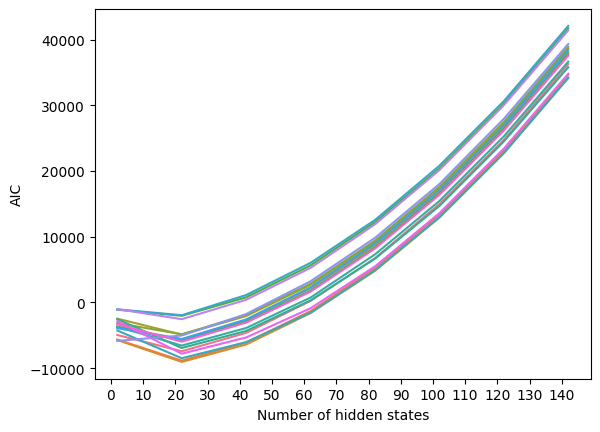

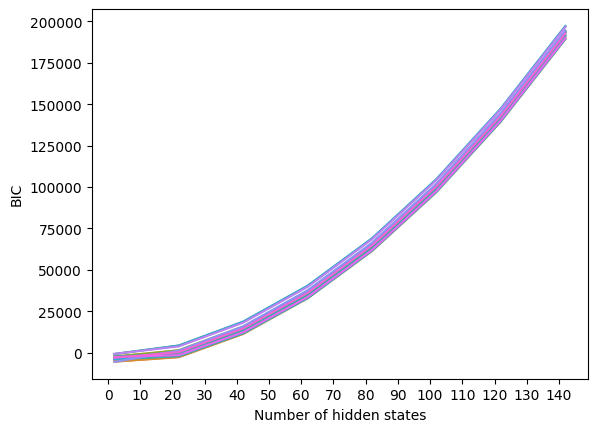

In [ ]:
States = list(range(start_step, last_state, state_step))

def generate_colors(num_colors):
    # Use seaborn's color_palette to generate a list of colors
    return sns.color_palette('husl', n_colors=num_colors)

# Generate the list of colors
colors = generate_colors(len(matrix_all))
Ks = np.array([(num_states + num_states*num_states + num_states*emission_dim*2) 
          for num_states in States])  # pi_init + transition_matrix + predictors_mean + predictors_var 

for s, session in enumerate(design_matrices[0:17]):
    avg_val_lls = all_lls[s]
    #avg_val_lls = all_lls
    baseline_lls = all_baseline_lls[s]
    #baseline_lls = all_baseline_lls
    bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
    
    plt.plot(all_num_states, bits_LL, color=colors[s], label=str(session))
    plt.legend()
    plt.xticks(States)
    plt.xlabel("Number of hidden states")
    plt.ylabel("$\Delta$ Log Likelihood ")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.xticks(np.arange(0, last_state, 10), np.arange(0, last_state, 10))
plt.legend().remove()
#plt.ylim([4,5])
plt.show()

for s, session in enumerate(design_matrices[0:17]):
    avg_val_lls = all_lls[s]
    #avg_val_lls = all_lls
    baseline_lls = all_baseline_lls[s]
    AIC = Ks * 2 - 2 * np.array(avg_val_lls)
    plt.plot(all_num_states, AIC, color=colors[s], label=str(session))
    plt.xticks(States)
    plt.xlabel("Number of hidden states")
    plt.ylabel("AIC")
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.legend().remove()
plt.xticks(np.arange(0, last_state, 10), np.arange(0, last_state, 10))
plt.show()


for s, session in enumerate(design_matrices[0:17]):
    avg_val_lls = all_lls[s]
    #avg_val_lls = all_lls
    BIC = Ks * np.log(fold_len) - 2 * np.array(avg_val_lls)
    #BIC = Ks * np.log(fold_len) - 2 * np.array(train_lls)
    plt.plot(all_num_states, BIC, color=colors[s], label=str(session))
    plt.legend()
    plt.xticks(States)
    plt.xlabel("Number of hidden states")
    plt.ylabel("BIC")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.xticks(np.arange(0, last_state, 10), np.arange(0, last_state, 10))
plt.legend().remove()

### Calculate model assessment metrics

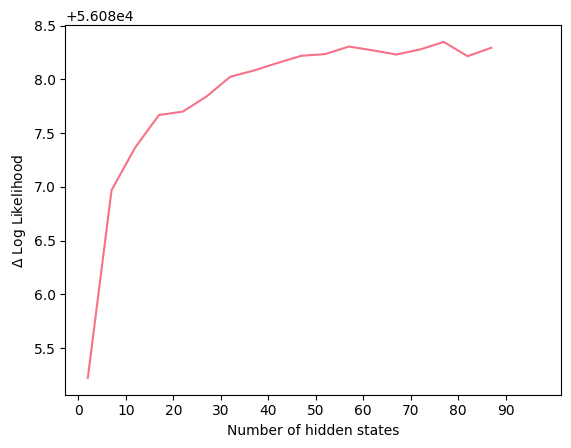

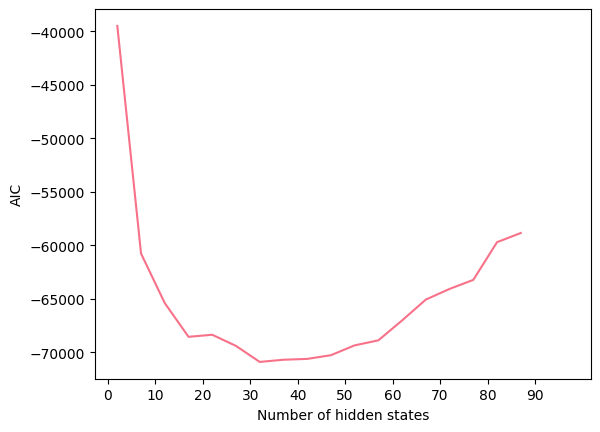

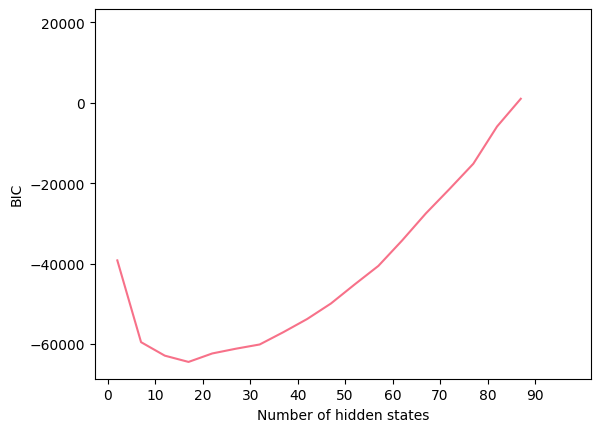

In [ ]:
States = list(range(2, last_state, state_step))

def generate_colors(num_colors):
    # Use seaborn's color_palette to generate a list of colors
    return sns.color_palette('husl', n_colors=num_colors)

# Generate the list of colors
colors = generate_colors(len(matrix_all))
Ks = np.array([(num_states + num_states*num_states + num_states*emission_dim*2) 
          for num_states in States])  # pi_init + transition_matrix + predictors_mean + predictors_var 

for s, session in enumerate(design_matrices[0:1]):
    avg_val_lls = all_lls[s]
    avg_val_lls = all_lls
    baseline_lls = all_baseline_lls[s]
    #baseline_lls = all_baseline_lls
    bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
    
    plt.plot(all_num_states, bits_LL, color=colors[s], label=str(session))
    plt.legend()
    plt.xticks(States)
    plt.xlabel("Number of hidden states")
    plt.ylabel("$\Delta$ Log Likelihood ")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.xticks(np.arange(0, 100, 10), np.arange(0, 100, 10))
plt.legend().remove()
#plt.ylim([4,5])
plt.show()

for s, session in enumerate(design_matrices[0:1]):
    avg_val_lls = all_lls[s]
    avg_val_lls = all_lls
    baseline_lls = all_baseline_lls[s]
    AIC = Ks * 2 - 2 * np.array(avg_val_lls)
    plt.plot(all_num_states, AIC, color=colors[s], label=str(session))
    plt.xticks(States)
    plt.xlabel("Number of hidden states")
    plt.ylabel("AIC")
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.legend().remove()
plt.xticks(np.arange(0, 100, 10), np.arange(0, 100, 10))
plt.show()


for s, session in enumerate(design_matrices[0:1]):
    avg_val_lls = all_lls[s]
    avg_val_lls = all_lls
    BIC = Ks * np.log(fold_len) - 2 * np.array(avg_val_lls)
    plt.plot(all_num_states, BIC, color=colors[s], label=str(session))
    plt.legend()
    plt.xticks(States)
    plt.xlabel("Number of hidden states")
    plt.ylabel("BIC")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))   
plt.xticks(np.arange(0, 100, 10), np.arange(0, 100, 10))
plt.legend().remove()
